# Final Homework - Fruits

This notebook is the stub you have to fill out for the homework. Read the task description and implement the empty code cells. Each section represents a stage along implementing an image classifier from loading and inspecting the dataset to making something working. The section descriptions contain what to do in that step.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [canvas.elte.hu](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Task description
Your task is to implement a deep learning classifier of fruit images. The dataset contains segmented images of 60 different fruits. You'll have to implement a convolutional network.

## Rules and Comments
- This is an ML class so to pass the homework you do have to implement a working classifier, just loading the data is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course)
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID in the box below for easier identification.

In [ ]:
# Keras 2.3.1 has a bug in evalutation, downgrade it
%tensorflow_version 1.x
!pip install -U keras==2.2.5

Requirement already up-to-date: keras==2.2.5 in /usr/local/lib/python3.6/dist-packages (2.2.5)


In [ ]:
# Some useful imports
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os, shutil
import glob
import cv2 as cv2
from sklearn.datasets import load_files
from keras.utils import to_categorical

In [ ]:
pip install split-folders

In [ ]:
pip install split-folders tqdm

In [ ]:
import split_folders

## Dataset preparations
First download the data and extract it:

In [ ]:
!wget http://vegesm.web.elte.hu/fruits_small.zip
!unzip fruits_small.zip > /dev/null

--2020-05-14 12:30:32--  http://vegesm.web.elte.hu/fruits_small.zip
Resolving vegesm.web.elte.hu (vegesm.web.elte.hu)... 157.181.1.225
Connecting to vegesm.web.elte.hu (vegesm.web.elte.hu)|157.181.1.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186322919 (178M) [application/zip]
Saving to: ‘fruits_small.zip.3’

fruits_small.zip.3  100%[===================>] 177.69M  1.76MB/s    in 2m 36s  

2020-05-14 12:33:08 (1.14 MB/s) - ‘fruits_small.zip.3’ saved [186322919/186322919]

replace fruits-small/test/Pear Monster/110_100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


This will download and extract the dataset into `/content/fruits-small`. You can inspect the files in the sidebar on the left, under the *Files* tab. The dataset contains 100x100 pixel images of fruits, grouped by classes into folders. 

Notice that the dataset does not define a validation set, you have to split it yourself. Split the training set into a training and validation set. Make sure in the validation set the classes have a similar distribution to the training set.



Now that you have set up the dataset, it's time to look at some of the images. Create a function that randomly selects 4 images and prints them with the class names.

In [ ]:
# Splitting the train dataset into train and validation sets:
split_folders.ratio('/content/fruits-small/train', output="new", seed=1337, ratio=(.8, .2))

In [ ]:
# Read the data from Folders and Sub-folders
# Directories for our train,val, test splits
train_dir = '/content/new/train'
val_dir = '/content/new/val'
test_dir = '/content/fruits-small/test'

# Function to read the folders and sub-folders
# Return lists of Data, Classes labels as integer, Labels names
def load_our_data(path):
  train1= []
  target= []
  target_labels= []
  i=0
  for folder in  os.listdir(path) : 
    files = glob.glob(pathname= str(path +'/' + folder + '/*.jpg'))
    for x in files:
      train1.append(cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB))
      target_labels.append(folder)
      target.append(i)
    i +=1
  return train1,target,target_labels 

In [ ]:
# Load the images and convert them into Numpy Array

x_train, y_train,target_labels = load_our_data(train_dir)
x_train = np.array(x_train)
print('Train set Shape : ',x_train.shape)

x_val, y_val,val_labels = load_our_data(val_dir)
x_val = np.array(x_val)
print('val set Shape : ',x_val.shape)

x_test, y_test, h = load_our_data(test_dir)
x_test = np.array(x_test)
print('Test set Shape : ',x_test.shape)

Train set Shape :  (24353, 100, 100, 3)
val set Shape :  (6115, 100, 100, 3)
Test set Shape :  (10332, 100, 100, 3)
24353
6115
10332


In [ ]:
# Convert labels data to one-hot encoding (vector of 60 elements)
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, len(np.unique(y_train)))
y_test = np_utils.to_categorical(y_test, len(np.unique(y_test)))

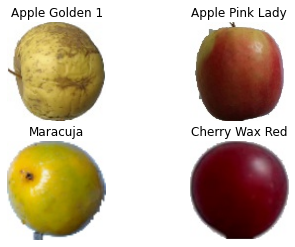

In [ ]:
# Function randomly selects 4 images and prints them with their labels
def RanPrint(folder):
  selected = np.random.choice(len(folder),4)
  plt.figure()
  for i, ind in enumerate(selected):
    plt.subplot(2,2,i+1)
    plt.imshow(folder[ind])
    plt.title(target_labels[ind])
    plt.axis('off')

RanPrint(x_train)

### Splitting the dataset

Notice that the dataset does not define a validation set, you have to split it yourself. Split the training set into a training and validation set. 

In [ ]:
# I already do this step at the first of this file ...



```
# This is formatted as code
```

### Preprocess the dataset

We need to augment the data, since we do not have many images per classes. Create an augmentation mechanism, data automatically does the following transformations during training:
- flip images horizontally
- rotates them
- performs zooming

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.2,
    horizontal_flip=True,
    )

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(100, 100),
        class_mode='categorical',
        batch_size=32,
        )

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(100, 100),
        class_mode='categorical',
        batch_size=32,
        )
test_generator = test_datagen.flow_from_directory(
        tesr_dir,
        target_size=(100, 100),
        class_mode='categorical',
        batch_size=32,
        )

## Training the network

Implement and train the following architecture. It has the following layers:

- A convolutional layer with 5x5 kernel and 32 filters
- A 2x2 MaxPooling layer
- Two convolutional layers with 3x3 kernels and 64 filters each
- A MaxPooling layer
- Another 3x3 convolutional layer with 128 filters, followed by a MaxPooling layer
- A fully connected layer of 512 units
- A final softmax layer

All layers have ReLU activations. Train the network for 15 epochs.

In [ ]:
from keras import layers
from keras import models
from keras import optimizers

# Define the model
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(60, activation='softmax'))

# Summary representation of our model
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 96, 96, 32)        2432      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 8, 8, 128)       

In [ ]:
# Configure the learning process
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# Training the neural network model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=760,# trainset length/32
      epochs=15,
      validation_data=validation_generator,
      validation_steps = 190) # valset length/32

Now, that the model has finished training, plot the accuracy and loss over time, both for training and validation data:

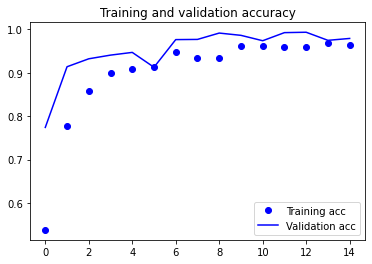

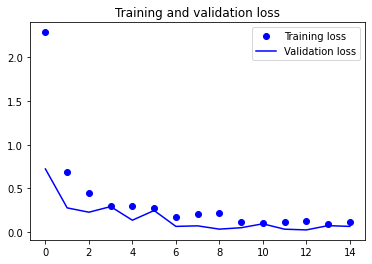

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

How did the loss and accuracy curves change over time? What does it mean regarding the training process (i.e. overfit, underfit, etc.)? Is that a problem and how would you solve it?

**Write your answers below**

We can see that we have underfitting because the val loss is under the train loss, we can solve it by adding more layers, more neurons and optimize the hyperparameters...

Finally, calculate the performance of your model on the test set:

In [ ]:
# Evaluate the model
loss, acc = model.evaluate.generator(x_test, y_test, verbose=0)
print('Test loss: {}'.format(loss))
print('Test accuracy: {:.2%}'.format(acc))


In [ ]:
loss, acc = model.evaluate_generator(test_generator,32, verbose=0)